# Convolutional Neural Network 구현
- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교.

In [1]:
import matplotlib.pyplot as plt
# 학습결과 그래프 함수
# loss 그래프
def plot_loss(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [2]:
# accuracy 그래프
def plot_accuracy(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
import numpy as np

In [4]:
np.random.seed(1)
tf.random.set_seed(1)

In [5]:
# 하이퍼파라미터 설정
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100
N_CLASS = 10

In [6]:
# 데이터셋 로드
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, train_label.shape, test_image.shape, test_label.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
# 추가 변수 설정
N_TRAIN = train_image.shape[0]
N_TEST = test_image.shape[0]

In [8]:
# 전처리: 이미지 - 정규화(0 ~ 1)
#       Label - OneHotEncoding(생략-loss: sparse_categorical_crossentropy)
X_train, X_test = train_image/255., test_image/255.
X_train = X_train[..., np.newaxis]  # gray scale 이미지이기 때문에, 1이라는 채널값을 목록에 추가해줘야 한다.
X_test = X_test[..., np.newaxis]
y_train, y_test = train_label, test_label

In [9]:
X_train.shape

(60000, 28, 28, 1)

In [10]:
# dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

# CNN 모델 구성
- convolution layer의 filter의 개수는 적은 개수에서 점점 늘려간다.
- input shape(입력 이미지의 size): 3차원 (height, width, channel)
    - 흑백: (height, width, 1)
    - 컬러: (height, width, 3)

In [11]:
def create_model():
    model = keras.Sequential()

    # Input shape
    model.add(layers.Input((28, 28, 1)))

    # Convolution Layer: Conv2D -> MaxPool2D
    model.add(layers.Conv2D(filters=32,  # Filter 개수
                            kernel_size=(3, 3),  # Filter(kernel)의 height, width. h와 w가 같은 경우에는 정수로 표현
                            padding='same',  # Padding 방식: valid, same 중 하나 (대소문자는 상관없다.)
                            strides=(1, 1),  # Stride 설정: (상하, 좌우) -> 상하, 좌우가 같은 값이면 정수로 표현
                            activation='relu'
                            ))
    # Max Pooling Layer -> MaxPool2D
    model.add(layers.MaxPool2D(pool_size=(2, 2),  # 영역 height, width 크기 설정. h와 w가 같으면 정수로 표현. default=(2, 2) = 2 -> Feature Map size를 절반으로 줄인다.
                               strides=(2, 2),  # default: None -> Pool size를 사용. 두개 값이 같으면 정수로 표현
                               padding='same'  # 'valid'인 경우, 뒤에 남는 것은 버린다는 의미
                               ))
    model.add(layers.Conv2D(filters=64,
                            kernel_size=3,
                            padding='same',
                            strides=1,
                            activation='relu'
                            ))
    model.add(layers.MaxPool2D(padding='same'))  # pool_size, strides: default값으로 설정

    # Classification Layer -> Fully Connected Layer
    # Conv 거친 Feature map은 3차원 배열 형태 -> Flatten 작업이 먼저 필요하다.
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))

    # Output Layer
    model.add(layers.Dense(N_CLASS, activation='softmax'))

    return model

In [12]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

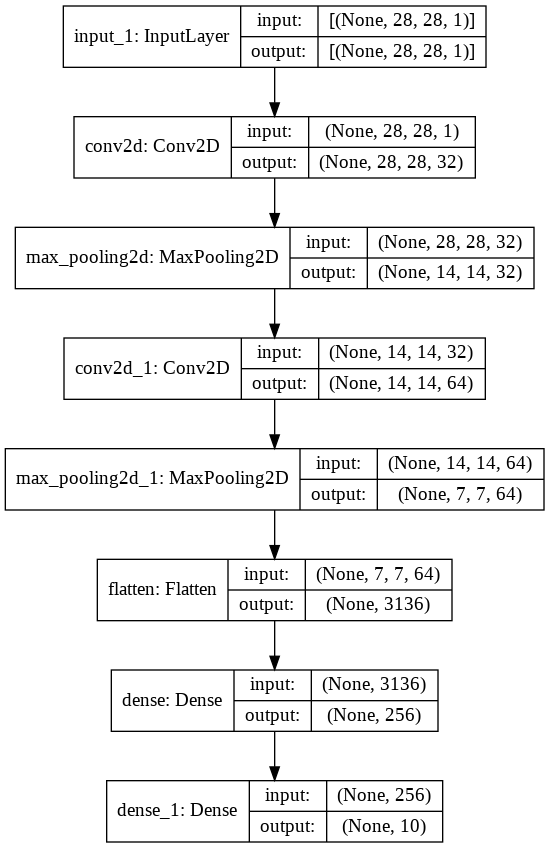

In [13]:
keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
               loss='sparse_categorical_crossentropy',  # y가 one hot encoding이 안된 경우 사용
               metrics=['accuracy']
               )

In [15]:
steps_per_epoch = N_TRAIN // N_BATCHS
validation_epochs = int(np.ceil(N_TEST / N_BATCHS))

history = model.fit(train_dataset,
                    epochs=N_EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_dataset,
                    validation_steps=validation_epochs)

Epoch 1/20
600/600 [==============================] - 36s 5ms/step - loss: 0.3778 - accuracy: 0.8821 - val_loss: 0.0425 - val_accuracy: 0.9862
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0454 - accuracy: 0.9863 - val_loss: 0.0348 - val_accuracy: 0.9889
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0286 - accuracy: 0.9914 - val_loss: 0.0284 - val_accuracy: 0.9902
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0222 - accuracy: 0.9929 - val_loss: 0.0337 - val_accuracy: 0.9889
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0254 - val_accuracy: 0.9916
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0264 - val_accuracy: 0.9920
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0314 - val_accuracy: 0.9901
Epoch

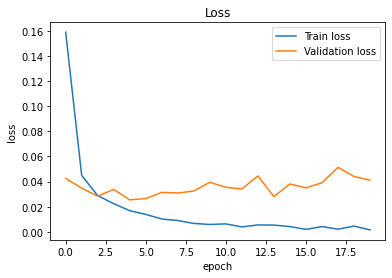

In [16]:
plot_loss(history)

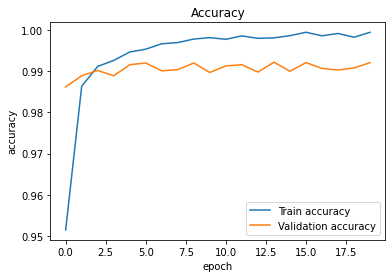

In [17]:
plot_accuracy(history)

In [18]:
model.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0411 - accuracy: 0.9921


[0.041082125157117844, 0.9921000003814697]

In [19]:
# 새로운 데이터 추론
pred = model.predict(X_test[:10])
pred_class = np.argmax(pred, axis=-1)

In [20]:
pred_class

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [21]:
y_test[:10]  # 정답값

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

### prediction error가 발생한 example 확인

In [22]:
pred = model.predict(X_test)
pred_class = np.argmax(pred, axis=-1)
pred_class[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [23]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

In [27]:
# 예측이 틀린 index를 조회
error_index = np.where(pred_class != y_test)[0]  # pred_class와 y_test에서 값이 다른 부분이 어디야? 하는 것
error_index.size, error_index

(79, array([ 321,  340,  445,  582,  583,  646,  659,  674,  882,  883,  947,
        1014, 1112, 1226, 1232, 1242, 1247, 1260, 1319, 1364, 1393, 1459,
        1527, 1709, 1790, 1828, 1878, 1901, 2035, 2118, 2129, 2130, 2135,
        2293, 2462, 2597, 2648, 2654, 2896, 2921, 2939, 2953, 2959, 3384,
        3422, 3558, 3727, 3762, 3794, 3850, 3853, 3906, 4176, 4201, 4443,
        4723, 4740, 4761, 4807, 4823, 4956, 5331, 5654, 5937, 6571, 6576,
        6597, 6625, 6651, 8094, 9009, 9015, 9587, 9638, 9642, 9664, 9692,
        9729, 9792]))

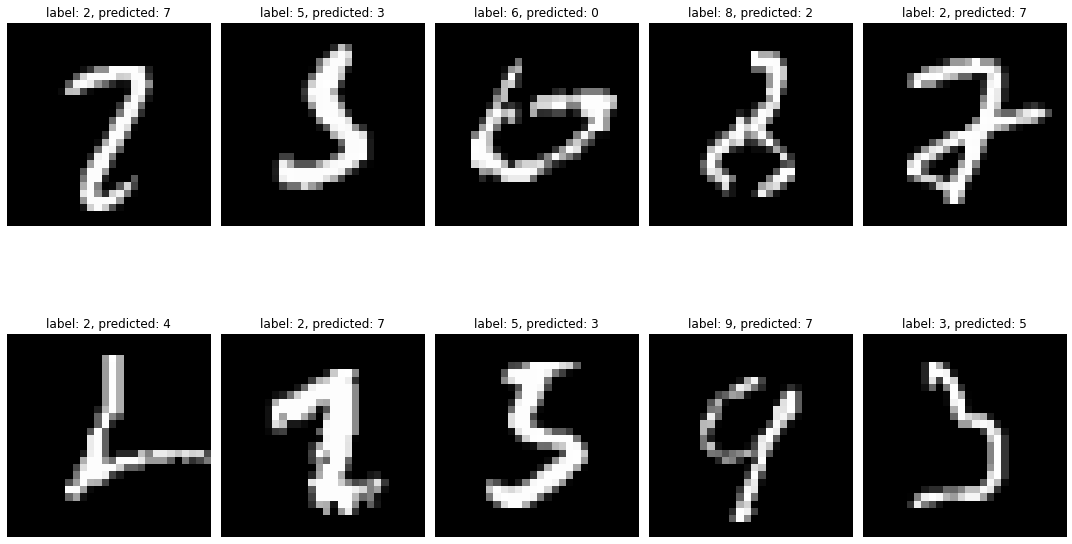

In [31]:
# 틀린 것 10개만 확인해보기
plt.figure(figsize=(15, 10))
for i in range(10):
    err = error_index[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(test_image[err], cmap='gray')
    plt.title(f'label: {y_test[err]}, predicted: {pred_class[err]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# 모델 저장
1. 학습이 끝난 모델의 파라미터만 저장
1. 모델 전체 저장
1. Callback 함수를 이용해 학습시 가장 좋은 지표의 모델 저장

## 텐서플로 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 파일타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 형식

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장: `model.save_weights("저장경로")`
- 불러오기: `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# 저장할 경로 생성
import os
base_dir = '/content/drive/MyDrive/Colab Notebooks/saved_models'  # 모델 / 파라미터들을 저장할 root
weight_dir = os.path.join(base_dir, 'mnist', 'weights')
print(weight_dir)
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir, exist_ok=True)
    # exist_ok=False(기본값): 이미 경로가 있으면 예외를 발생시킴 / True: 예외를 발생시키지 않음
weight_path = os.path.join(weight_dir, 'mnist_cnn_weights.ckpt')  # 저장할 디렉토리 + 파일명

/content/drive/MyDrive/Colab Notebooks/saved_models/mnist/weights


In [34]:
model.save_weights(weight_path)

In [35]:
new_model1 = create_model()
new_model1.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss='sparse_categorical_crossentropy',  # y가 one hot encoding이 안된 경우 사용
                   metrics=['accuracy']
                   )

In [36]:
new_model1.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.3126 - accuracy: 0.1780


[2.313303232192993, 0.17180000245571136]

In [37]:
# 저장된 weight들을 생성된 모델(네트워크)에 저장
new_model1.load_weights(weight_path)

In [38]:
new_model1.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0411 - accuracy: 0.9921


[0.041082125157117844, 0.9921000003814697]

In [40]:
# hdf5 형식으로 불러오기
weight_h5_dir = os.path.join(base_dir, 'mnist', 'weights_h5')
if not os.path.isdir(weight_h5_dir):
    os.makedirs(weight_h5_dir)
weight_h5_path = os.path.join(weight_h5_dir, 'mnist_cnn_weight.h5')
print(type(weight_h5_path), weight_h5_path)

<class 'str'> /content/drive/MyDrive/Colab Notebooks/saved_models/mnist/weights_h5/mnist_cnn_weight.h5


In [41]:
model.save_weights(weight_h5_path, save_format='h5')

In [42]:
new_model2 = create_model()
new_model2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss='sparse_categorical_crossentropy',  # y가 one hot encoding이 안된 경우 사용
                   metrics=['accuracy']
                   )

In [43]:
new_model2.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.3159 - accuracy: 0.0876


[2.315847158432007, 0.08489999920129776]

In [44]:
new_model2.load_weights(weight_h5_path)
new_model2.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0411 - accuracy: 0.9921


[0.041082125157117844, 0.9921000003814697]

## 전체 모델 저장하고 불러오기
- 저장: `model.save('저장할디렉토리')`
- 불러오기: `tf.keras.models.load_model('저장파일경로')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 로 지정한다.
    

In [46]:
model_dir = os.path.join(base_dir, 'mnist', 'models', 'saved_model')
if not os.path.isdir(model_dir):
    os.makedirs(model_dir, exist_ok=True)
print(model_dir) 

/content/drive/MyDrive/Colab Notebooks/saved_models/mnist/models/saved_model


In [47]:
model.save(model_dir)  # SavedModel 형식으로 저장 시 디렉토리를 저장

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/saved_models/mnist/models/saved_model/assets


In [48]:
new_model3 = tf.keras.models.load_model(model_dir)

In [49]:
new_model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [50]:
new_model3.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0411 - accuracy: 0.9921


[0.041082125157117844, 0.9921000003814697]

In [51]:
# h5형식으로 저장하고 불러오기
model_h5_dir = os.path.join(base_dir, 'mnist', 'models', 'h5_model')
if os.path.isdir(model_h5_dir):
    os.makedirs(model_h5_dir, exist_ok=True)
# h5형식으로 저장시에는 파일명까지 지정한다.
model_h5_path = os.path.join(model_h5_dir, 'mnist_cnn_model.h5')

In [52]:
model.save(model_h5_path, save_format='h5')

In [53]:
new_model4 = keras.models.load_model(model_h5_path)

In [54]:
new_model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [55]:
new_model4.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 0.0411 - accuracy: 0.9921


[0.041082125157117844, 0.9921000003814697]

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- `EarlyStopping`: Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈춤
    - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
    - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 
- `ModelCheckpoint`: 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight를 저장하여 overfitting이 발생하기 전의 model을 나중에 불러들여 사용할 수 있음
    - `save_best_only=True`: monitoring 중인 measure를 기준으로 최적의 모형의 weight만 저장 
- **callback 객체들을 리스트로 묶은 뒤 fit()의 callback 매개변수에 전달한다.**

In [56]:
model2 = create_model()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
model2.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 2.2994 - accuracy: 0.1350


[2.3011434078216553, 0.12770000100135803]

In [59]:
callback_dir = os.path.join(base_dir, 'mnist', 'models', 'callback')
if not os.path.isdir(callback_dir):
    os.makedirs(callback_dir, exist_ok=True)
callback_path = os.path.join(callback_dir, 'saved_model_{epoch:02d}.ckpt')  # {epoch:02d}: 포맷문자열 형식

In [75]:
# Model Checkpoint Callback 생성
mc_callback = keras.callbacks.ModelCheckpoint(filepath=callback_path,  # 학습 도중에 모델 / 파라미터를 저장할 경로
                                              save_weights_only=True,  # True: 가중치만 저장, False(default): 모델 + 가중치를 저장
                                              save_best_only=True,  # True: 가장 성능이 좋았을 때만 저장, False(default): 매 epoch마다 저장
                                              monitor='val_loss',  # save_best_only가 True일 때 성능을 확인할 평가지표
                                              verbose=1,  # 저장 시마다 로그를 출력
                                             )
# EarlyStopping Callback 생성
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5)  # 5번 epoch를 학습하는 동안에 val_loss가 좋아지지 않으면 학습을 멈춘다.

In [76]:
history = model2.fit(train_dataset,
                     epochs=N_EPOCHS,
                     steps_per_epoch=steps_per_epoch,
                     validation_data=test_dataset,
                     validation_steps=validation_epochs,
                     callbacks=[mc_callback, es_callback]
                    )

Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0418 - val_accuracy: 0.9918

Epoch 00001: val_loss improved from inf to 0.04184, saving model to /content/drive/MyDrive/Colab Notebooks/saved_models/mnist/models/callback/saved_model_01.ckpt
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0485 - val_accuracy: 0.9914

Epoch 00002: val_loss did not improve from 0.04184
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0365 - val_accuracy: 0.9931

Epoch 00003: val_loss improved from 0.04184 to 0.03655, saving model to /content/drive/MyDrive/Colab Notebooks/saved_models/mnist/models/callback/saved_model_03.ckpt
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0372 - val_accuracy: 0.9929

Epoch 00004: val_loss did not improve from 0.0365

In [77]:
# 저장된 weight loading
new_model5 = create_model()
new_model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
# weight들이 저장된 디렉토리를 지정하면 마지막 epoch에서 저장된 weight를 불러온다.
best_weights = tf.train.latest_checkpoint(callback_dir)

In [79]:
new_model5.load_weights(best_weights)

In [80]:
new_model5.evaluate(test_dataset)

100/100 [==============================] - 1s 3ms/step - loss: 0.0473 - accuracy: 0.9909


[0.03654634580016136, 0.9930999875068665]